## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

僅506筆資料(訓練資料404組；測試資料102組)

每個特徵取值是介於一個區間的連續值(如：0～1、1~12..)

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


**數據集有13個特徵衡量房價**

In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

**標籤資料是房價(千美元)，是我們要進行迴歸預測的目標**

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

###**數據標準化與正規化**

__正規化(Min-max Scaling)，0~1:__
$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}}$$
```
def normalization(raw):
    max_value = max(raw)
    min_value = min(raw)
    norm = [(float(i)-min_value)/(max_value-min_value) for i in raw]
    return norm
```

__標準化(z-score)，轉為$(\mu,\sigma)=(0,1)$:__
$$X_{z.score}=\frac{X-\bar{X}}{\sigma}$$
註：下面程式是套公式不是用zscore(x)，我認為是因為zscore(x)是用母體標準差算，但公式是樣本標準差。
```
from scipy.stats import zscore
z_score = zscore(x)
```


**Normalizing the data**

如上所述，因為各組特徵的區間範圍不固定(如：0～1、1~12..)，宜使用**標準化**進行數據預處理：

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

編譯模型

| 問題種類 | 損失函數 | 選擇 |
| :--- | :---| :---|
|二元分類 |binary_crossentropy| ○|
|單標籤多元分類 |categorical_crossentropy| ○|
|多標籤多元分類 |binary_crossentropy| ○|
|迴歸分析 |mse| ●|
|迴歸值在0~1之間 |mse 或 binary_crossentropy| ○|

評估指標使用平均絕對誤差`mae`：例如MAE為0.5，表示預測偏離500美金。

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) #由於最後⼀層是純線性的，因此模型可以⾃由地學習預測任何範圍(沒指定啟動函數)。
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

**若k=3:**

<img src="https://i.imgur.com/voKMUjv.jpg">





In [ ]:
k = 4
num_val_samples = len(train_data) // k # 確定每一折有多少資料數
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # 跳過Validation Data ，合併Training Data
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**將4折的mae結果印出**

In [ ]:
all_scores

[1.9123655557632446, 2.4559056758880615, 2.5381009578704834, 2.460628032684326]

**對4折的結果取平均。**

平均mae約為2.3，表示與預測誤差2300美金左右

In [ ]:
np.mean(all_scores)

2.341750055551529

**Saving the validation logs at each fold**

同樣k=4，但使用更多訓練週期(500)，以確定最佳週期防止過度擬合

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

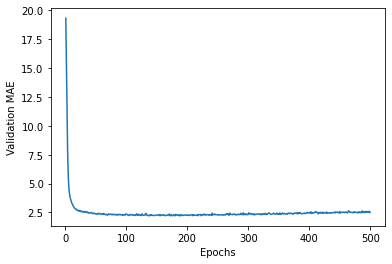

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

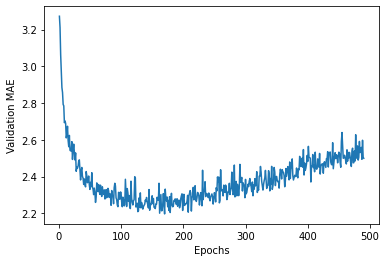

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

由上面結果可知訓練周期約120-140開始過度擬合，這邊採用130：

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 13.9143 - mae: 2.5365


In [ ]:
test_mae_score

2.536496877670288

### Generating predictions on new data

預測新數據對應之房價

In [ ]:
predictions = model.predict(test_data)
print(predictions[0])
print("第一棟房子之預測價格為：",predictions[0]*1000,'美元')

[8.88706]
第一棟房子之預測價格為： [8887.061] 美元


### Wrapping up

## Summary

請看本文章最頂處，我在文初做好了摘要